In [1]:
import networkx as nx
import pickle
import random
import scipy
from scipy.sparse import tril, find
import django
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import igraph
from django.core.management import call_command

sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.tasks import *
import tmv_app
import tmv_app.utils.plotting as tplots
from tmv_app.utils.plotting import SquareCollection, CoordSquare
import importlib

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [12]:
run_id = 2914 
stat = RunStats.objects.get(pk=run_id)
q = stat.query

# position the papers in a 2-dimensional topic space, with perplexity p
# unless you pass the argument force_overwrite=True, the results are not recalculated
s = 0
p = 100
tsne_results, r_ind = stat.calculate_tsne('tsne_results/data', p)

In [3]:
tsne_results

array([[ -6.85888522,  -4.02933313],
       [-21.25695256,   6.78557197],
       [ -6.75845479, -10.84353249],
       ...,
       [-17.30479879,  14.08643436],
       [-15.46903115, -19.46293086],
       [  1.29502089, -13.24225391]])

In [4]:
tsne_df = pd.DataFrame(tsne_results)
tsne_df.columns = ["tsne-1","tsne-2"]
tsne_df['doc_id'] = r_ind
print(tsne_df.shape)
tsne_df.to_csv('../DIFID/data/tsne_results.csv',index=False)
tsne_df.head()

(16964, 3)


,tsne-1,tsne-2,doc_id
0,-6.858885,-4.029333,1474561
1,-21.256953,6.785572,3440643
2,-6.758455,-10.843532,3538950
3,-9.208449,-1.926575,1474569
4,-0.552565,14.896720,2097161


In [9]:
dts = pd.DataFrame.from_dict(
    DocTopic.objects.filter(run_id=run_id).values('doc_id','topic_id','score')
)
dts.to_csv('../DIFID/data/doctopic.csv',index=False)

dts.pivot(index="doc_id",columns="topic_id",values="score").fillna(0).to_csv('../DIFID/data/doctopic_wide.csv')

In [6]:
topic_df = pd.DataFrame.from_dict(
    Topic.objects.filter(run_id=run_id).values('id','title','top_words')
)
topic_df.to_csv('data/topic_info.csv',index=False)
#topic_df.to_csv('../DIFID/data/topic_info.csv',index=False)
topic_df.head()

,id,title,top_words
0,212274,"Infection, Infectious disease","[diseas, infecti, respiratori, cardiovascular,..."
1,212321,"Mental, Mental health","[mental, health, disord, physic, psycholog, di..."
2,212322,"Drought, Drought","[drought, impact, index, veget, sever, agricul..."
3,212323,"Suicide, Suicide","[suicid, associ, rate, attempt, male, men, stu..."
4,212327,"Daily, Daily data & trends","[day, daili, period, dure, visit, number, incr..."


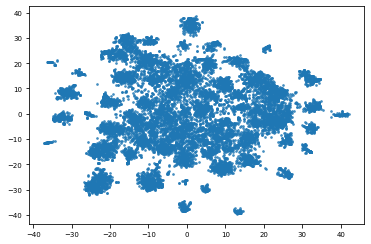

In [7]:
plt.scatter(tsne_results[:,0],tsne_results[:,1], s=3, alpha=0.7)

In [8]:
doc_info = pd.read_csv('data/doc_information.csv')
doc_info.head()

,id,title,content,PY,wc__oecd,wosarticle__di,continent
0,3255833,Assessment of spatiotemporal variability of re...,Reference evapotranspiration (ETo) is a key co...,2019.0,NaN,10.1016/j.agwat.2018.09.037,Asia
1,3537962,Predicting the Effects of Nanoscale Cerium Add...,Diesel vehicles are a major source of air poll...,2014.0,NaN,10.1021/es504050g,NaN
2,3687033,Persistent foci of falciparum malaria among tr...,"Background: Koraput, a predominantly tribe-inh...",2013.0,NaN,10.1186/1475-2875-12-72,Asia
3,3446429,Spatial and temporal variation of dengue incid...,Background: Dengue fever control in the tropic...,2019.0,NaN,10.1016/j.tmaid.2019.06.008,Asia
4,3637781,Barriers to keeping warm in later life,Aim To identify factors influencing older peop...,2013.0,NaN,10.7748/nop2013.12.25.10.22.e434,NaN


In [9]:
doc_info.continent.unique()

array(['Asia', nan, 'North America', 'Oceania', 'South America', 'Europe',
       'Africa'], dtype=object)

In [10]:
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
continent_cats = []
nocontinent_ids = r_ind
for i,(name, group) in enumerate(doc_info[~pd.isna(doc_info["continent"])].groupby('continent')):
    c = {}
    ds = group["id"].values
    c['docs'] = list(set(ds) & set(r_ind))
    c['n_docs'] = len(c['docs'])
    c['name'] = name
    c['color'] = colors[i]
    c["dis"] = np.argwhere(np.isin(r_ind,c['docs']))
    nocontinent_ids = nocontinent_ids[np.isin(nocontinent_ids,c['docs'],invert=True)]
    print(c["name"])
    continent_cats.append(c)    

Africa
Asia
Europe
North America
Oceania
South America


calculating points took 0.125s.


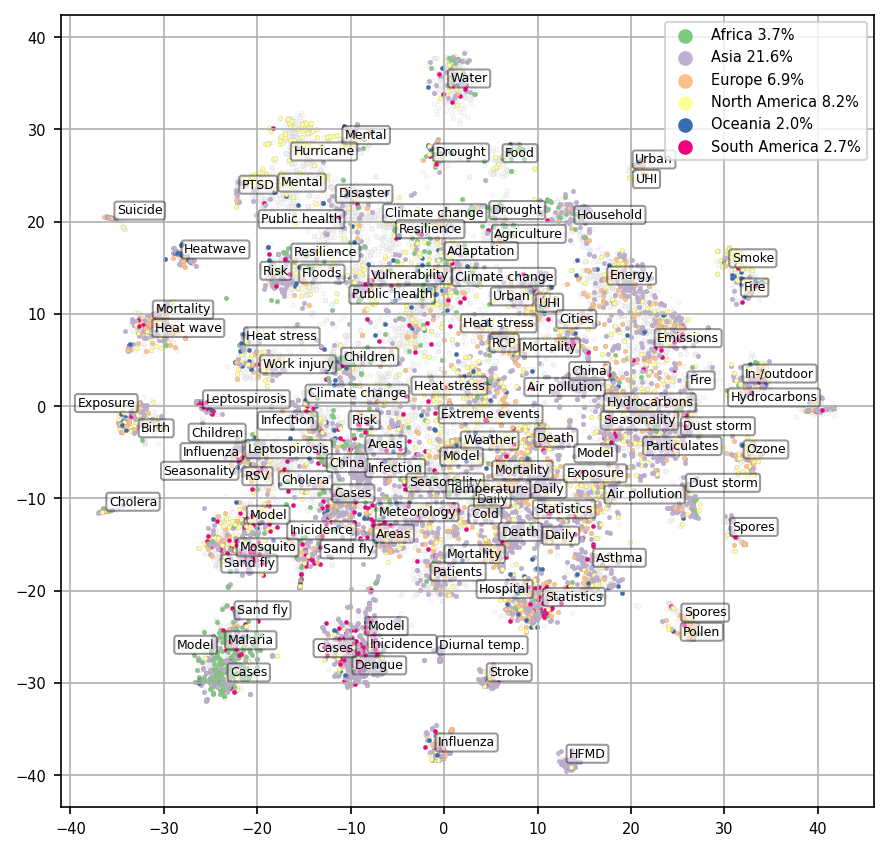

In [11]:
fig, ax = plt.subplots( figsize=(7,7), dpi=150)

tops = Topic.objects.filter(run_id=run_id)

labels = tplots.plot_tsne(
    r_ind,
    tsne_results,
    continent_cats,
    nocontinent_ids,
    verbose=True,
    ax=ax,
    psize=5, #pointsize
    topics=tops, 
    clabel_size=6,
    t_thresh=0.9, # threshold for percentile of document topic scores above which to include
    min_cluster=40, # minimum number of documents to label cluster
    eps=2, # Input for clustering, higher values allow larger distances between docs 
    draw_highlight_points=False,
    adjust=True,
    dot_legend=True,
    #words_only=False,
    words_only=True
)

In [12]:
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
no_oecd_ids = r_ind

oecd_cats = [
    {'wc__oecd': 'Agricultural Sciences'},
    {'wc__oecd': 'Engineering and Technology'},
    {'wc__oecd': 'Humanities'},
    {'wc__oecd': 'Medical and Health Sciences'},
    {'wc__oecd': 'Natural Sciences'},
    {'wc__oecd': 'Social Sciences'},
    {'wc__oecd': None}
]

oecd_df = pd.DataFrame()
for i,c in enumerate(oecd_cats):
    ds = Doc.objects.filter(query=q,wc__oecd=c['wc__oecd']).values_list('id', flat=True)
    c['docs'] = list(set(ds) & set(r_ind))
    oecd_df = pd.concat([oecd_df,pd.DataFrame({
        "oecd": c['wc__oecd'], "doc": c['docs']
    })])
    c['n_docs'] = len(c['docs'])
    c['name'] = c['wc__oecd']
    c['color'] = colors[i]
    c["dis"] = np.argwhere(np.isin(r_ind,c['docs']))
    no_oecd_ids = no_oecd_ids[np.isin(no_oecd_ids,c['docs'],invert=True)]
    
from operator import itemgetter
oecd_cats = sorted(oecd_cats, key=itemgetter('n_docs'), reverse=True)


calculating points took 0.193s.
couldn't find a cluster for {dtr, diurnal, effect}


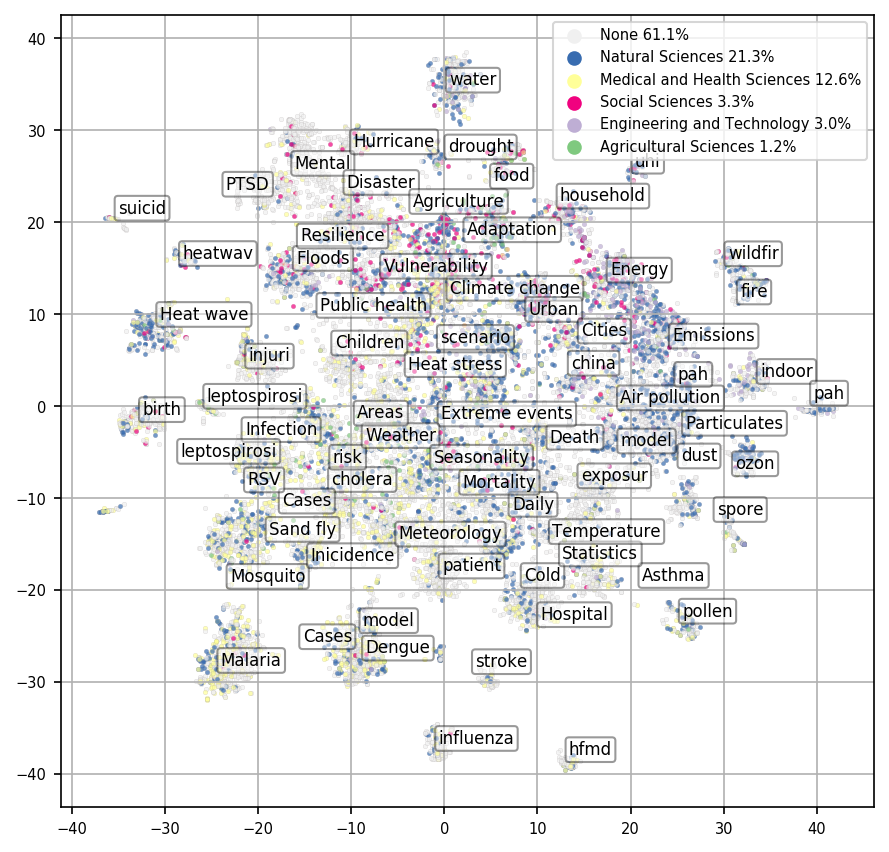

In [11]:
texts[0].get_text()

In [13]:
df = pd.read_csv('IdLabelPrediction.csv')
df.head()

,id,label,prediction
0,3546488,NaN,0.011372
1,2399733,NaN,0.295782
2,730310,NaN,0.180741
3,3371201,NaN,0.013280
4,3369993,NaN,0.002478


In [14]:
seen_df = df[pd.notna(df['label'])]
seen_df['error'] = seen_df['prediction'] - seen_df['label']
print(seen_df.shape)
seen_df.head()

(3641, 4)


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,label,prediction,error
95,3428617,0.0,0.020495,0.020495
126,3463532,0.0,0.027111,0.027111
267,3438250,0.0,0.014785,0.014785
330,3463969,0.0,0.025826,0.025826
399,1526887,0.0,0.281766,0.281766


In [15]:
import matplotlib.cm as cm
import matplotlib as mpl

norm = mpl.colors.DivergingNorm(vmin=-1, vcenter=0., vmax=1)
cmap = cm.RdBu
m = cm.ScalarMappable(norm=norm, cmap=cmap)

no_label_ids = r_ind
label_cats = []
for i in np.arange(-1,1,step=0.2):
    c = {}
    ds = seen_df.loc[(seen_df['error']>=i) & (seen_df['error']<i+0.2),"id"].values
    c['docs'] = list(set(ds) & set(r_ind))
    c['n_docs'] = len(c['docs'])
    c['name'] = f"{i:.1f}<error<{i+0.2:.1f}"
    c['color'] = mpl.colors.to_hex(m.to_rgba(i+0.5))
    c["dis"] = np.argwhere(np.isin(r_ind,c['docs']))
    no_label_ids = no_label_ids[np.isin(no_label_ids,c['docs'],invert=True)]
    print(c["name"])
    label_cats.append(c)    


-1.0<error<-0.8
-0.8<error<-0.6
-0.6<error<-0.4
-0.4<error<-0.2
-0.2<error<-0.0
-0.0<error<0.2
0.2<error<0.4
0.4<error<0.6
0.6<error<0.8
0.8<error<1.0


calculating points took 0.214s.


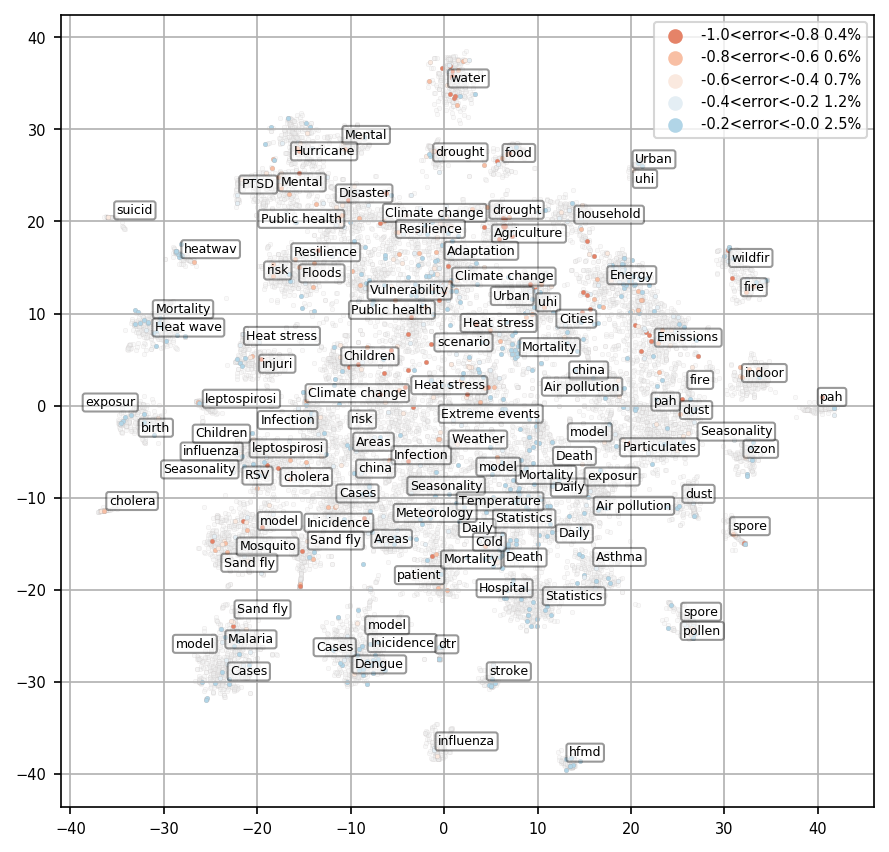

In [16]:
fig, ax = plt.subplots( figsize=(7,7), dpi=150)

tops = Topic.objects.filter(run_id=run_id)

tplots.plot_tsne(
    r_ind,
    tsne_results,
    label_cats,
    no_label_ids,
    verbose=True,
    ax=ax,
    psize=5, #pointsize
    topics=tops, 
    clabel_size=6,
    t_thresh=0.9, # threshold for percentile of document topic scores above which to include
    min_cluster=40, # minimum number of documents to label cluster
    eps=2, # Input for clustering, higher values allow larger distances between docs 
    draw_highlight_points=False,
    adjust=True,
    dot_legend=True,
    #words_only=False,
    words_only=True
)

In [17]:
colors = ['#ef8a62','#67a9cf']
no_label_ids = r_ind
label_cats = []
for i,label in enumerate([1,0]):
    c = {}
    ds = df.loc[df['label']==label,"id"].values
    c['docs'] = list(set(ds) & set(r_ind))
    c['n_docs'] = len(c['docs'])
    c['name'] = label
    c['color'] = colors[i]
    c["dis"] = np.argwhere(np.isin(r_ind,c['docs']))
    no_label_ids = no_label_ids[np.isin(no_label_ids,c['docs'],invert=True)]
    label_cats.append(c)
    
from operator import itemgetter
label_cats = sorted(label_cats, key=itemgetter('n_docs'), reverse=True)

In [18]:
for l in label_cats:
    print(l['n_docs'])

930
0


calculating points took 0.076s.


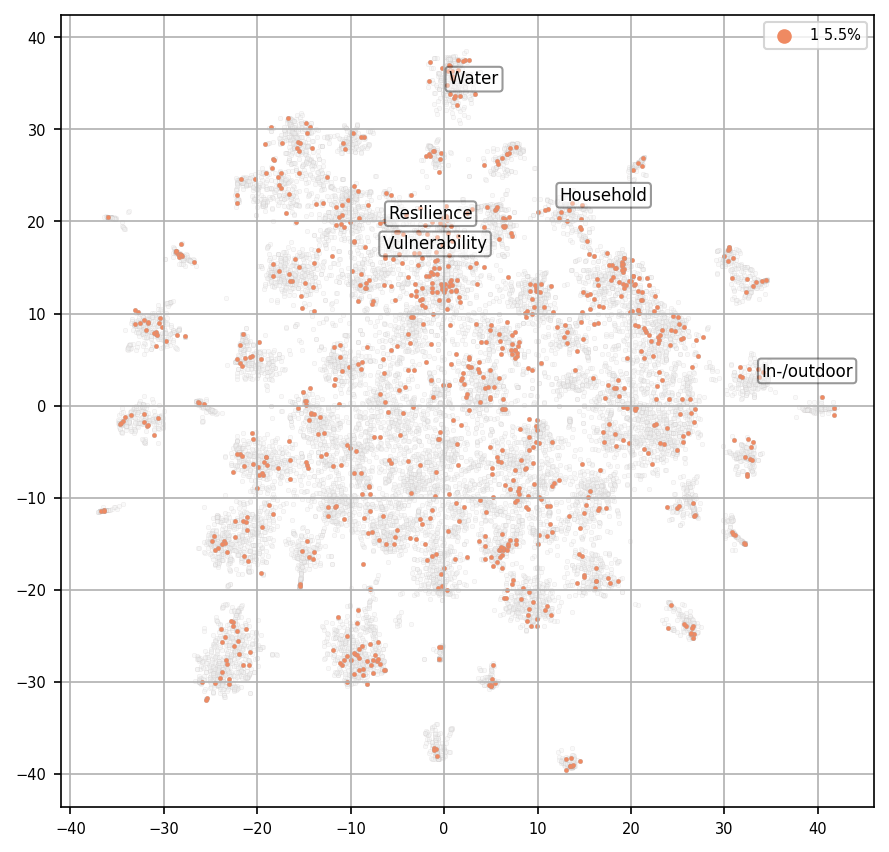

In [19]:
fig, ax = plt.subplots( figsize=(7,7), dpi=150)

tops = Topic.objects.filter(run_id=run_id)[:5]

tplots.plot_tsne(
    r_ind,
    tsne_results,
    label_cats,
    no_label_ids,
    verbose=True,
    ax=ax,
    psize=5, #pointsize
    topics=tops, 
    t_thresh=0.94, # threshold for percentile of document topic scores above which to include
    min_cluster=80, # minimum number of documents to label cluster
    eps=5, # Input for clustering, higher values allow larger distances between docs 
    draw_highlight_points=False,
    adjust=True,
    dot_legend=True,
    #words_only=False,
    words_only=True
)

In [20]:
qds = set(q.doc_set.values_list('pk',flat=True))
len(qds)

16964

In [21]:
labeled = set(df[pd.notna(df['label'])]['id'])
len(labeled)

3641

In [22]:
len(labeled & qds)

930

In [23]:
colors = ['#ef8a62','#67a9cf']
no_label_ids = r_ind
label_cats = []
for i,q in enumerate(["prediction<0.5","prediction>0.5"]):
    c = {}
    ds = df.query(q)["id"].values
    c['docs'] = list(set(ds) & set(r_ind))
    c['n_docs'] = len(c['docs'])
    c['name'] = q
    c['color'] = colors[i]
    c["dis"] = np.argwhere(np.isin(r_ind,c['docs']))
    no_label_ids = no_label_ids[np.isin(no_label_ids,c['docs'],invert=True)]
    label_cats.append(c)
    
from operator import itemgetter
label_cats = sorted(label_cats, key=itemgetter('n_docs'), reverse=True)

calculating points took 0.067s.


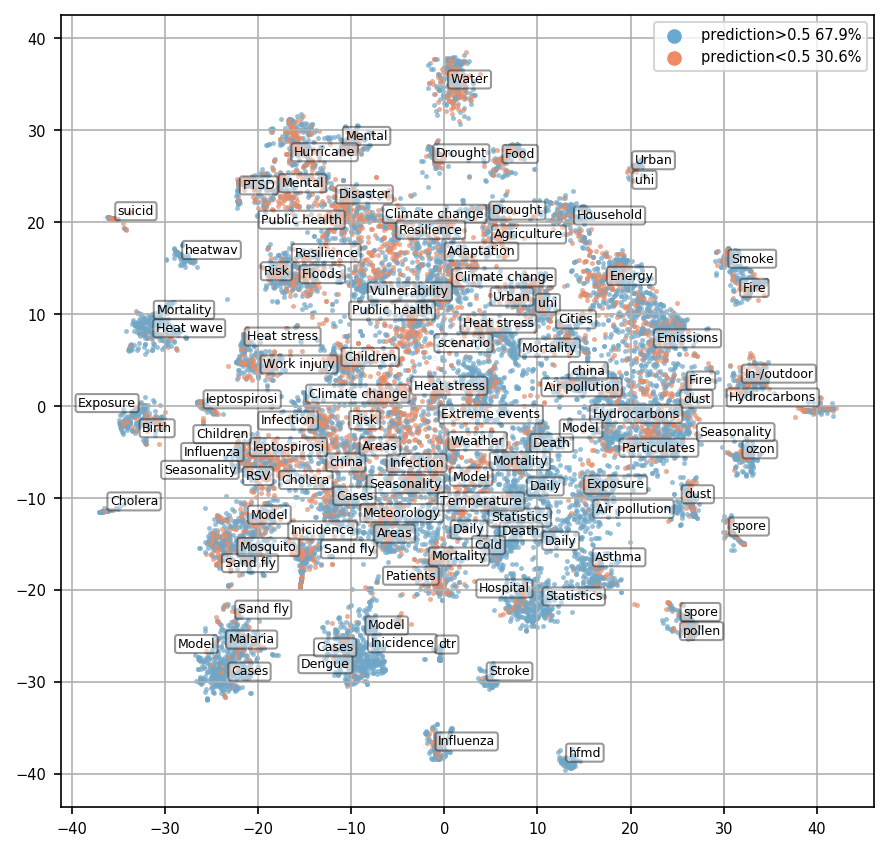

In [24]:
fig, ax = plt.subplots( figsize=(7,7), dpi=150)

tops = Topic.objects.filter(run_id=run_id)#[:5]

tplots.plot_tsne(
    r_ind,
    tsne_results,
    label_cats,
    no_label_ids,
    verbose=True,
    ax=ax,
    psize=5, #pointsize
    topics=tops, 
    clabel_size=6,
    t_thresh=0.9, # threshold for percentile of document topic scores above which to include
    min_cluster=40, # minimum number of documents to label cluster
    eps=2, # Input for clustering, higher values allow larger distances between docs 
    draw_highlight_points=False,
    adjust=True,
    dot_legend=True,
    #words_only=False,
    words_only=True
)

### Colour based on category

In [30]:
df = pd.read_csv('IdCategoryPrediction.csv')
df.head()

,id,label,adaptation,mitigation,impact
0,1639326,NaN,0.563154,0.012469,0.541731
1,3729468,NaN,0.563328,0.006591,0.016033
2,3234989,NaN,0.057740,0.011866,0.536156
3,3406276,NaN,0.011754,0.004777,0.315730
4,2418301,NaN,0.335438,0.008179,0.397113


In [31]:
df.sum()

id            3.875859e+10
label         9.300000e+02
adaptation    1.517974e+03
mitigation    1.573231e+03
impact        9.172655e+03
dtype: float64

In [32]:
df['max'] = df[[ 'mitigation', 'adaptation','impact']].idxmax(axis = 1)
df[df['max'] == 'mitigation'].shape

(1711, 6)

In [33]:
import matplotlib.cm as cm
import matplotlib as mpl

categories = df['max'].unique()

norm = mpl.colors.DivergingNorm(vmin=-1, vcenter=0., vmax=1)
colors = ['#7fc97f','#beaed4','#f0027f']

no_label_ids = r_ind
label_cats = []
for i, cat in enumerate(categories):
    c = {}
    ds = df.loc[(df['max']== cat),"id"].values
    c['docs'] = list(set(ds) & set(r_ind))
    c['n_docs'] = len(c['docs'])
    c['name'] = cat
    c['color'] = colors[i]
    c["dis"] = np.argwhere(np.isin(r_ind,c['docs']))
    no_label_ids = no_label_ids[np.isin(no_label_ids,c['docs'],invert=True)]
    print(c["name"])
    label_cats.append(c)    

adaptation
impact
mitigation


calculating points took 0.092s.
couldn't find a cluster for Diurnal temp., Diurnal temperature range


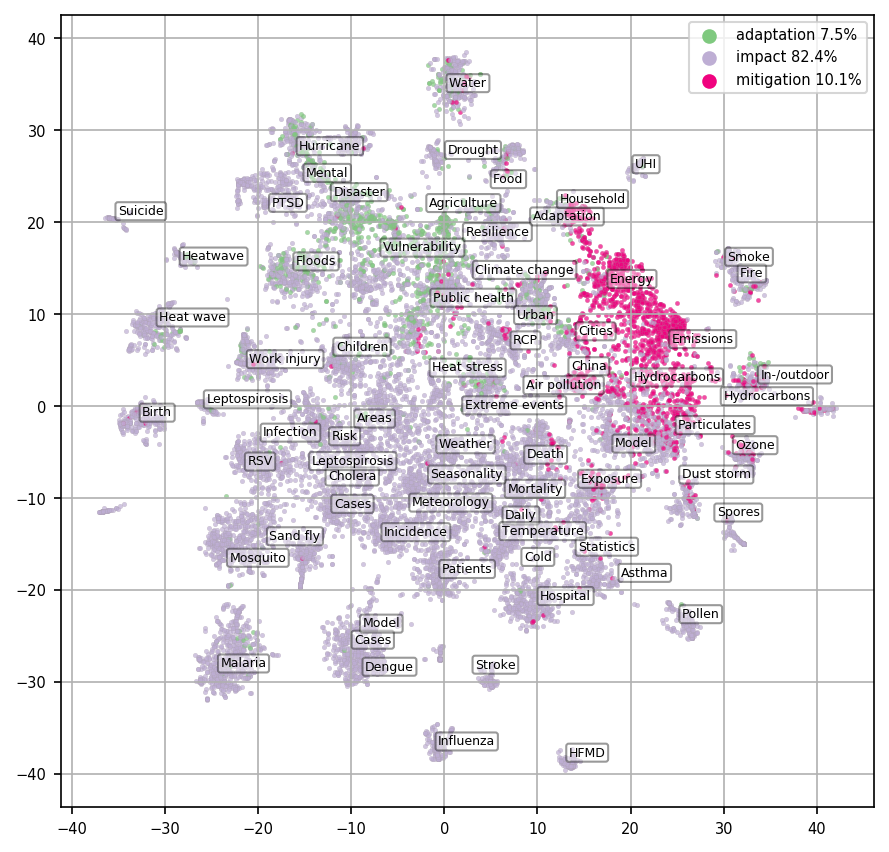

In [34]:
fig, ax = plt.subplots( figsize=(7,7), dpi=150)

tops = Topic.objects.filter(run_id=run_id)[:5]

tplots.plot_tsne(
    r_ind,
    tsne_results,
    label_cats,
    no_label_ids,
    verbose=True,
    ax=ax,
    psize=5, #pointsize
    clabel_size=6,
    topics=tops, 
    t_thresh=0.94, # threshold for percentile of document topic scores above which to include
    min_cluster=80, # minimum number of documents to label cluster
    eps=5, # Input for clustering, higher values allow larger distances between docs 
    draw_highlight_points=False,
    adjust=True,
    dot_legend=True,
    #words_only=False,
    words_only=True
)

In [8]:
dts = DocTopic.objects.filter(topic=t,run_id=run_id).order_by('-score')
dts.first().doc.title

'Socio-environmental drivers and suicide in Australia: Bayesian spatial analysis'

In [13]:
tts = TopicTerm.objects.filter(topic=t, run_id=run_id).order_by('-score')
tts.first().term.title

'factor'

In [14]:
#relevant_ids = df.filter('prediction>0.5')
relevant_ids = [0,500,2000,1000,500000]

In [19]:
df = pd.DataFrame.from_dict(DocTopic.objects.filter(
    run_id=run_id
).values('topic__title').annotate(
    n = Sum('score')
)).sort_values('n')
df.head()

,topic__title,n
15,"{potenti, larg, better}",123.860815
73,"{death, due, caus}",124.026587
46,"{respiratori, emerg, visit}",124.509616
4,"{onli, particular, limit}",124.606340
14,"{factor, prevent, explor}",125.084054


In [ ]:
plt

In [16]:
DocTopic.objects.filter(
    run_id=run_id,
    doc__id__in=relevant_ids
).values('topic__title').annotate(
    n = Sum('score')
)

<PostgresQuerySet []>

In [24]:
TopicCorr.objects.filter(
    run_id=run_id,score__lt=1
).order_by('-score').values(
    'topic__title','topiccorr__title','score'
)[:5]

<QuerySet [{'topic__title': '{adapt, strategi, product}', 'topiccorr__title': '{polici, plan, mitig}', 'score': 0.4346762315963888}, {'topic__title': '{polici, plan, mitig}', 'topiccorr__title': '{adapt, strategi, product}', 'score': 0.4346762315963888}, {'topic__title': '{mortal, cardiovascular, elder}', 'topiccorr__title': '{day, lag, cold}', 'score': 0.4190444678352178}, {'topic__title': '{day, lag, cold}', 'topiccorr__title': '{mortal, cardiovascular, elder}', 'score': 0.4190444678352178}, {'topic__title': '{research, need, understand}', 'topiccorr__title': '{adapt, strategi, product}', 'score': 0.41308726718941335}]>

In [25]:
TopicCorr.objects.filter(
    run_id=run_id,
    score__lt=1,
    topic=t
).order_by('-score').values(
    'topic__title','topiccorr__title','score'
)[:5]

<QuerySet [{'topic__title': '{factor, prevent, explor}', 'topiccorr__title': '{relat, humid, china}', 'score': 0.18231297548665348}, {'topic__title': '{factor, prevent, explor}', 'topiccorr__title': '{relat, humid, china}', 'score': 0.17429064416462153}, {'topic__title': '{factor, prevent, explor}', 'topiccorr__title': '{inform, conduct, preval}', 'score': 0.15567469796838002}, {'topic__title': '{factor, prevent, explor}', 'topiccorr__title': '{case, incid, infect}', 'score': 0.14564014903671224}, {'topic__title': '{factor, prevent, explor}', 'topiccorr__title': '{case, incid, infect}', 'score': 0.14247995553955212}]>